In [37]:
import instaseis
import obspy
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patches as patches
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular'
print(plt.style.available)
plt.style.use('seaborn-ticks')
import numpy as np
from tqdm import tqdm
%matplotlib inline

['seaborn-pastel', 'seaborn-darkgrid', 'seaborn-white', 'seaborn-ticks', 'dark_background', 'seaborn-deep', 'grayscale', 'seaborn-whitegrid', 'classic', 'bmh', 'seaborn-talk', 'ggplot', 'fivethirtyeight', 'seaborn-poster', 'seaborn-paper', 'seaborn-dark-palette', 'seaborn-muted', 'seaborn-notebook', 'seaborn-dark', 'seaborn-bright', 'seaborn-colorblind']


In [2]:
db = instaseis.open_db('/import/freenas-m-02-seismology/staehler/Europa_5km_stronghet/')

In [3]:
def calc_phase_spec(tr, starttime, endtime, fwins=None):
    # Body waves
    tr_cut = tr.slice(starttime, endtime)
    p, f = mlab.psd(tr_cut.data, 
                    Fs=tr_cut.stats.sampling_rate,
                    NFFT=1000, pad_to=2048, noverlap=512)
    pmeans = []
    for fwin in fwins:
        fwin_mid = (fwin[1] + fwin[0]) / 2
        fwin_hw = (fwin[1] - fwin[0]) / 2
        pmeans.append(np.mean(10*np.log10(p[abs(1./f - fwin_mid) < fwin_hw])))
    return pmeans, p, f 

def plot_self_noises(ax):
    # Load SP self-noise data
    seis_types = ['STS2', '10Hz_geophone', 
                  'Trillium_compact']
    period = dict()
    psd = dict()
    style = dict()
    size = dict()
    color = dict()
    for seis in seis_types:
        filename = 'Fig_6/noise_%s.txt' % seis
        #print('Loading %s' % filename)
        selfnoise = np.loadtxt(filename)
        period[seis] = 1. / (selfnoise[1:, 0])
        psd[seis] = 10 * np.log10(selfnoise[1:, 1]) * 2
        style[seis] = '--'
        size[seis] = 2.0

    color['STS2'] = 'darkgrey' # 'cyan'
    color['10Hz_geophone'] = 'darkgrey' #'yellow'
    color['Trillium_compact'] = 'darkgrey' #'fuchsia'
    style['STS2'] = '-' # 'cyan'
    style['10Hz_geophone'] = ':' #'yellow'
    style['Trillium_compact'] = '--' #'fuchsia'

    # Add SP self noise plot
    for seis in seis_types:
        line, = ax.plot(period[seis], psd[seis], linewidth=size[seis],
                        color=color[seis], linestyle=style[seis],
                        label='%s self-noise' % seis)
    return ax

In [4]:
strikes = np.random.rand(100) * 360
rakes = np.random.rand(100) * 360
dips = np.random.rand(100) * 90
depths = np.random.rand(100) * 5e3

lat_pert = np.random.rand(100) * 5.
lon_pert = np.random.rand(100) * 360 - 180

In [5]:
fwins = [[1., 10.],
         [10, 80.],
         [80, 400.]]

pmeans_all = []
psums = dict()

dists = np.arange(10, 180, 5)
dists = [90]

for dist in dists:
    rec = instaseis.Receiver(latitude=90 - dist, longitude=0, station='EUR')

    #print(dist)
    pmeans = dict()
    psums[str(dist)] = dict()
    
    for chan in ['R', 'T', 'Z']:
        for phase in ['bw', 'ai', 'lv']:
            code = '%s_%s' % (phase, chan)
            pmeans[code] = []
            psums[str(dist)][code] = np.zeros(1025)
    
    c = {'R': 'b',
         'T': 'g',
         'Z': 'k'}
    t = dict()

    dist_km = dist / 180. * np.pi * 1561

    arr_airy = dist_km / 3.2
    arr_love = dist_km / 1.95
    t['bw_R'] = [obspy.UTCDateTime(arr_airy*0.5), obspy.UTCDateTime(arr_airy*0.9)]
    t['bw_T'] = [obspy.UTCDateTime(arr_airy*0.5), obspy.UTCDateTime(arr_airy*0.9)]
    t['bw_Z'] = [obspy.UTCDateTime(arr_airy*0.5), obspy.UTCDateTime(arr_airy*0.9)]

    t['ai_R'] = [obspy.UTCDateTime(arr_airy*0.9), obspy.UTCDateTime(arr_airy*1.3)]
    t['ai_T'] = [obspy.UTCDateTime(arr_airy*0.9), obspy.UTCDateTime(arr_airy*1.3)]
    t['ai_Z'] = [obspy.UTCDateTime(arr_airy*0.9), obspy.UTCDateTime(arr_airy*1.3)]

    t['lv_R'] = [obspy.UTCDateTime(arr_love-100), obspy.UTCDateTime(arr_love+700)]
    t['lv_T'] = [obspy.UTCDateTime(arr_love-100), obspy.UTCDateTime(arr_love+700)]
    t['lv_Z'] = [obspy.UTCDateTime(arr_love-100), obspy.UTCDateTime(arr_love+700)]

    for strike, dip, rake, depth, lat, lon in tqdm(zip(strikes, dips, rakes, depths, lat_pert, lon_pert)):
        src = instaseis.Source.from_strike_dip_rake(latitude=90 - lat, 
                                                    longitude=lon, M0=1e14, 
                                                    depth_in_m=depth, strike=strike, rake=rake, dip=dip)

        st = db.get_seismograms(src, rec, components='RTZ', kind='acceleration')
        #st.filter('highpass', freq=1./400.)

        tr = dict()
        tr['R'] = st.select(channel='*R')[0]
        tr['T'] = st.select(channel='*T')[0]
        tr['Z'] = st.select(channel='*Z')[0]

        for chan in ['R', 'T', 'Z']:
            for phase in ['bw', 'ai', 'lv']:
                code = '%s_%s' % (phase, chan)
                pm, p, f = calc_phase_spec(tr[chan], t[code][0], t[code][1], fwins)
                psums[str(dist)][code] += p
                pmeans[code].append(pm)
        

0it [00:00, ?it/s]/opt/anaconda/envs/Py35/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
100it [06:49,  5.83s/it]


/opt/anaconda/envs/Py35/lib/python3.5/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda/envs/Py35/lib/python3.5/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda/envs/Py35/lib/python3.5/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in true_divide


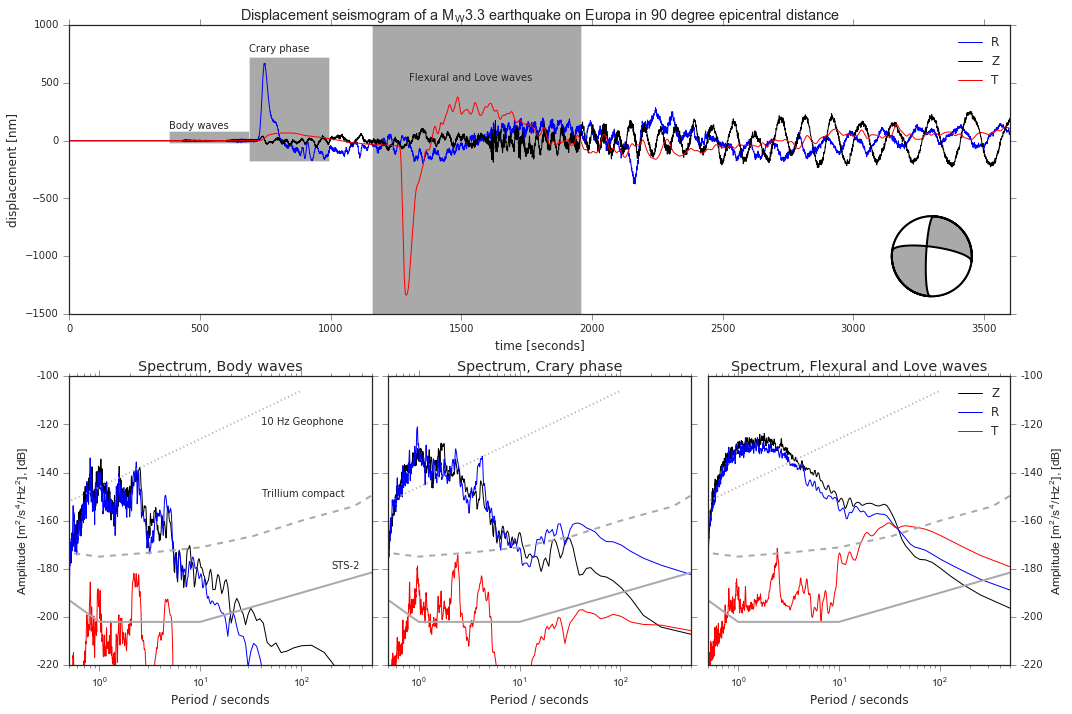

In [38]:
desc = {'bw': 'Spectrum, Body waves',
        'ai': 'Spectrum, Crary phase',
        'lv': 'Spectrum, Flexural and Love waves'}

c = {'Z': 'k',
     'R': 'b',
     'T': 'r'}

fig = plt.figure(figsize=(15,10))

ax0 = fig.add_subplot(211)
for chan in c:
    tr_work = tr[chan].copy()
    tr_work.integrate()
    tr_work.integrate()
    tr_work.filter('bandpass', freqmin=1./1500, freqmax=1./1.)
    ax0.plot(tr_work.times(), tr_work.data * 1e9, color=c[chan], label=chan)

desc_patch = {'bw': 'Body waves' % src.moment_magnitude,
              'ai': 'Crary phase' % src.moment_magnitude,
              'lv': 'Flexural and Love waves' % src.moment_magnitude}

heights = {'bw': 100,
           'ai': 900,
           'lv': 10400}
for part in ['bw', 'ai', 'lv']: 
    #height = 3e-7 #max(tr_work.data) / 2
    code = '%s_%s' % (part, chan)
    ax0.add_patch(patches.Rectangle(xy=[t[code][0], -heights[part] * 0.2],
                                    width = float(t[code][1] - t[code][0]),
                                    height = heights[part],
                                    facecolor='darkgrey'))
ax0.text(t['bw_R'][0], heights['bw'] * 1.05, desc_patch['bw'])              
ax0.text(t['ai_R'][0], heights['ai'] * 0.85, desc_patch['ai'])
ax0.text(1300, 520, desc_patch['lv'])

ax0.legend()
ax0.set_ylabel('displacement [nm]')
ax0.set_xlabel('time [seconds]')
ax0.set_xlim((0, 3600))
ax0.add_collection(beach((strike, dip, rake), xy=(3300, -1000), width=80, axes=ax0,
                          facecolor='darkgrey', bgcolor = 'white'))
ax0.set_title('Displacement seismogram of a $M_W$%3.1f earthquake on Europa in %2d degree epicentral distance' % 
              (src.moment_magnitude, dist))
 
ax = dict()
ax = {'bw': fig.add_subplot(234),
      'ai': fig.add_subplot(235),
      'lv': fig.add_subplot(236)}



for part in ['bw', 'ai', 'lv']:
    l_Z, = ax[part].plot(1./f, 10 * np.log10(psums['90']['%s_Z' % part] * 0.01), c['Z'])
    l_R, = ax[part].plot(1./f, 10 * np.log10(psums['90']['%s_R' % part] * 0.01), c['R'])
    l_T, = ax[part].plot(1./f, 10 * np.log10(psums['90']['%s_T' % part] * 0.01), c['T'])
    plot_self_noises(ax[part])
    ax[part].semilogx()
    ax[part].set_xlim(0.5, 500)
    ax[part].set_ylim(-220, -100)
    ax[part].set_title(desc[part])
    ax[part].set_xlabel('Period / seconds')
    ax[part].set_yticklabels([])
    
ax['bw'].set_ylabel('Amplitude [$m^2/s^4/Hz^2$], [dB]')
ax['bw'].set_yticks(np.arange(-220, -99, 20))
ax['bw'].set_yticklabels(np.arange(-220, -99, 20))

ax['lv'].set_ylabel('Amplitude [$m^2/s^4/Hz^2$], [dB]')
ax['lv'].yaxis.set_label_position("right")
ax['lv'].set_yticklabels(np.arange(-220, -99, 20))
ax['lv'].yaxis.set_ticks_position("right")


ax['bw'].text(40, -120, '10 Hz Geophone')
ax['bw'].text(40, -150, 'Trillium compact')
ax['bw'].text(200, -180, 'STS-2')
ax['lv'].legend([l_Z, l_R, l_T], ['Z', 'R', 'T'])
plt.tight_layout()

fig.savefig('Figure_6.png')